In [1]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# LDDMM landmark stochastic dynamics

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.manifolds.landmarks import *
M = landmarks(4)
print(M)
from src.plotting import *

4 landmarks in R^2 (dim 8). kernel Gaussian, k_alpha=1, k_sigma=[[0.5 0. ]
 [0.  0.5]]


In [4]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

In [5]:
# example configuration
M.k_sigma = jnp.diag(jnp.array([.5,.5]))

## Brownian Motion

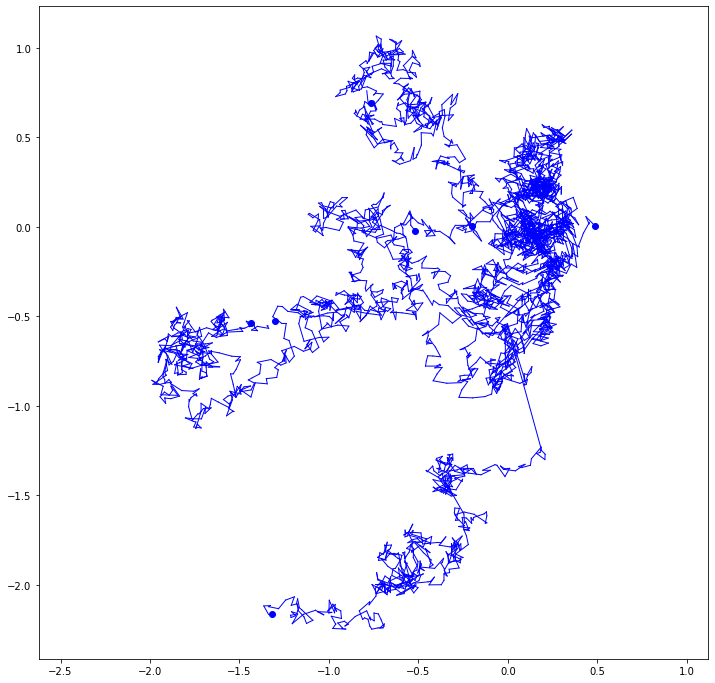

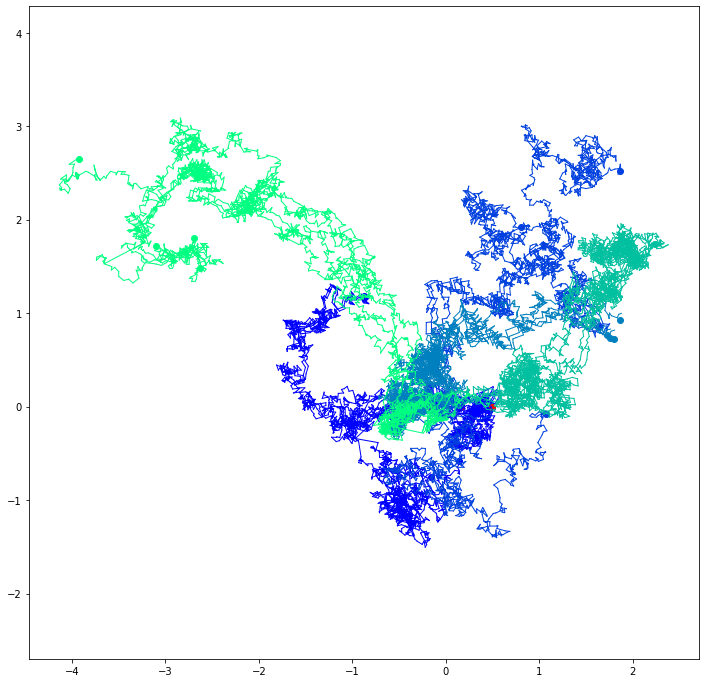

In [6]:
# coordinate form
from src.stochastics import Brownian_coords
Brownian_coords.initialize(M)

q = M.coords(jnp.vstack((np.linspace(-.5,.5,M.N),np.zeros(M.N))).T.flatten())

(ts,xs,charts) = M.Brownian_coords(q,dWs(M.dim,n_steps=1000))

# plot
M.newfig()
M.plot()
M.plot_path(zip(xs,charts))
plt.show()

# plot multiple sample paths
N = 5
xss = np.zeros((N,xs.shape[0],M.dim))
chartss = np.zeros((N,xs.shape[0],q[1].shape[0]))
for i in range(N):
    (ts,xs,charts) = M.Brownian_coords(q,dWs(M.dim,n_steps=xs.shape[0]))
    xss[i] = xs
    chartss[i] = charts

# plot
M.newfig()
M.plot()
colormap = plt.get_cmap('winter')
colors=[colormap(k) for k in np.linspace(0, 1, N)]
for i in range(N):
    M.plot_path(zip(xss[i],chartss[i]),color=colors[i])
M.plotx(q,color='r')
plt.show()

# Langevin equations
see https://arxiv.org/abs/1605.09276

q =  (DeviceArray([-0.5       ,  0.        , -0.43333334,  0.        ,
             -0.36666667,  0.        , -0.3       ,  0.        ,
             -0.23333333,  0.        , -0.16666667,  0.        ,
             -0.1       ,  0.        , -0.03333334,  0.        ,
              0.03333334,  0.        ,  0.1       ,  0.        ,
              0.16666667,  0.        ,  0.23333333,  0.        ,
              0.3       ,  0.        ,  0.36666667,  0.        ,
              0.43333334,  0.        ,  0.5       ,  0.        ],            dtype=float32), DeviceArray([0.], dtype=float32))
p =  [    0.       465.         0.     -1672.         0.      2538.
     0.     -2375.         0.      1506.         0.      -252.5
     0.      -160.         0.      -347.125      0.       312.
     0.       -66.0625     0.        83.         0.       108.
     0.       -58.25       0.      -248.5        0.       211.5
     0.       -37.75  ]


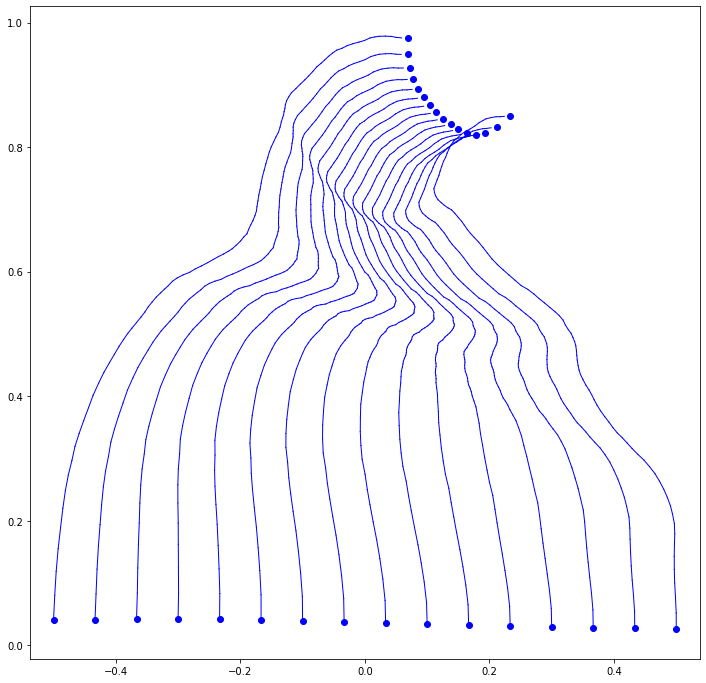

In [7]:
from src.stochastics import Langevin
Langevin.initialize(M)

M.setN(16)
q = M.coords(jnp.vstack((np.linspace(-.5,.5,M.N),np.zeros(M.N))).T.flatten())
v = jnp.array(jnp.vstack((np.zeros(M.N),np.ones(M.N))).T.flatten())

p = M.flat(q,v)
print("q = ", q)
print("p = ", p)

(ts,qps,charts) = M.Langevin(q,p,.5,.25,dWs(M.dim))

# plot
M.newfig()
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
plt.show()

## Stochastic EPDiff / Eulerian

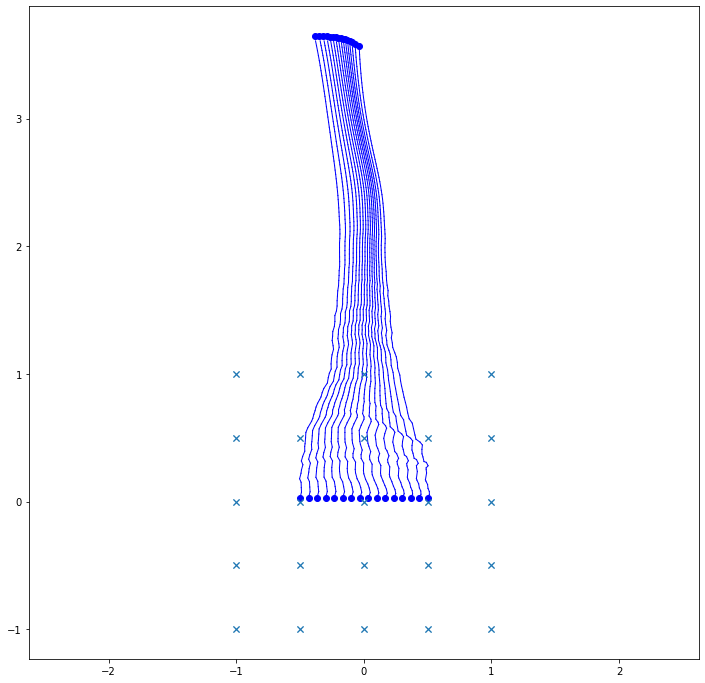

In [8]:
# define noise field grid
minx = -1; maxx = 1
miny = -1; maxy = 1
pts = 5

X, Y = jnp.meshgrid(np.linspace(minx,maxx,pts),np.linspace(miny,maxy,pts))
xy = jnp.vstack([X.ravel(), Y.ravel()]).T
sigmas_x = jnp.hstack((xy,xy)).reshape((-1,2))
sigmas_a = .05*jnp.tile(np.eye(2),(sigmas_x.shape[0]//2,1))
#sigmas_x = np.array([[0.,0.]])
#sigmas_a = np.array([[.1,0.]])
J = sigmas_x.shape[0]

# noise kernels
k_alpha = 1.
k_sigma = jnp.diag(jnp.array([(maxx-minx)/(pts-1),(maxy-miny)/(pts-1)]))
inv_k_sigma = jnp.linalg.inv(k_sigma)
k = lambda x: M.k_alpha*jnp.exp(-.5*jnp.square(jnp.tensordot(x,M.inv_k_sigma,(x.ndim-1,1))).sum(x.ndim-1))

# initialize with specified noise kernel
from src.stochastics import Eulerian
Eulerian.initialize(M,k=k)

# integrate
(ts,qps,charts) = M.Eulerian(q,p,sigmas_x,sigmas_a,dWs(J))

# plot
M.newfig()
M.plot()
M.plot_path(zip(qps[:,0,:],charts))
plt.plot(sigmas_x[:,0],sigmas_x[:,1],'x')
plt.show()

CPU times: user 241 ms, sys: 314 µs, total: 241 ms
Wall time: 220 ms
Size of noise basis:  4096
CPU times: user 149 ms, sys: 7.8 ms, total: 157 ms
Wall time: 144 ms


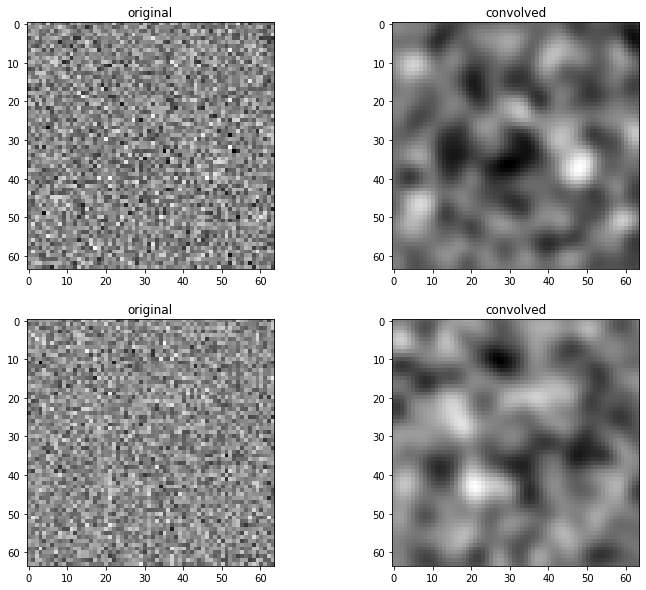

In [9]:
from scipy import misc
import jax.scipy as jsp

# generate stochastic images
global key
keys = jax.random.split(key)
key = keys[0]
subkeys = keys[1:]
%time images = jnp.sqrt(T/n_steps)*random.normal(subkeys[0],(n_steps,64,64,M.m))
image = images[0,:,:]

print("Size of noise basis: ", images.shape[1]*images.shape[2])

# Smooth the noisy image with a 2D Gaussian smoothing kernel.
scale = 1
x = jnp.linspace(-3, 3, 17)
window = jsp.stats.norm.pdf(x,0,scale) * jsp.stats.norm.pdf(x[:, None],0,scale)
%time smooth_image = jax.vmap(lambda im: jsp.signal.convolve(im, window, mode='same'),2,2)(image)

# plot
fig, ax = plt.subplots(M.m, 2, figsize=(12, 10))
for i in range(M.m):
    ax[i,0].imshow(image[:,:,i], cmap='binary_r')
    ax[i,0].set_title('original')
    ax[i,1].imshow(smooth_image[:,:,i], cmap='binary_r')
    ax[i,1].set_title('convolved');


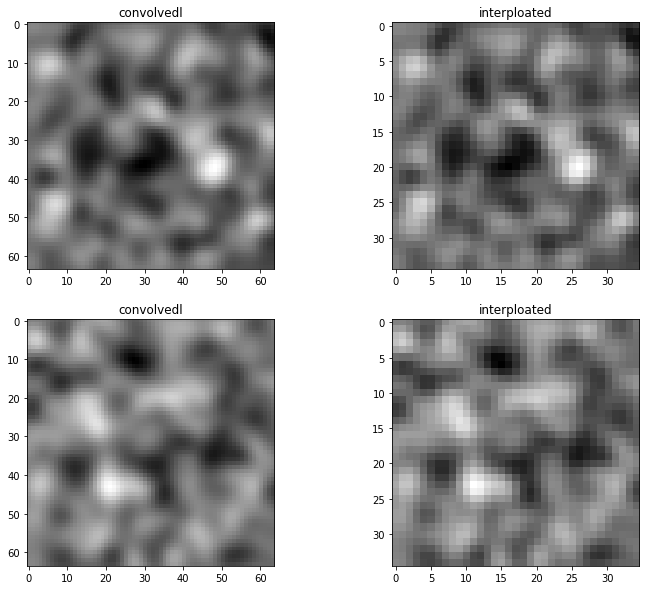

In [10]:
X, Y = np.meshgrid(jnp.linspace(0,63,35),jnp.linspace(0,63,35))
new_image = jax.vmap(lambda im: jsp.ndimage.map_coordinates(im.T,jnp.vstack((X.flatten(),Y.flatten())),order=1),
                     2,1)(smooth_image).reshape(X.shape+(M.m,))
fig, ax = plt.subplots(M.m, 2, figsize=(12, 10))
for i in range(M.m):
    ax[i,0].imshow(smooth_image[:,:,i], cmap='binary_r')
    ax[i,0].set_title('convolvedl')
    ax[i,1].imshow(new_image[:,:,i], cmap='binary_r')
    ax[i,1].set_title('interploated');

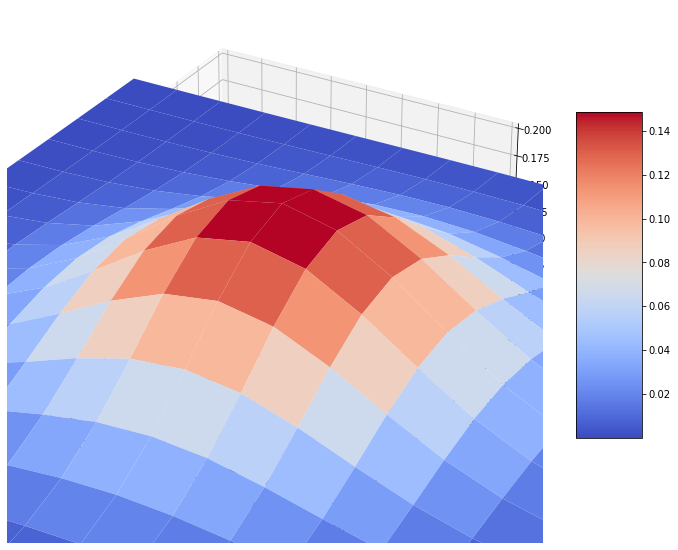

In [11]:
from matplotlib import cm
(_,ax) = newfig3d()
X, Y = np.meshgrid(x,x)
surf = ax.plot_surface(X,Y,window,cmap=cm.coolwarm)
# Customize the z axis.
ax.set_zlim(0, .2)
fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax)
plt.show()

In [12]:
# smoothing kernel for Q^{1/2}
kernel_dim = 17
x = jnp.linspace(-3, 3, kernel_dim)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None],0)
convolve = jax.vmap(lambda dW: jsp.signal.convolve(dW, window, mode='same'),2,2)
interpolate = jax.vmap(lambda Q12dW,q: jsp.ndimage.map_coordinates(Q12dW.T,q.T,order=1),(2,None),1)

def sde_Eulerian_infdim_noise(q,dW):
    # multiply noise on Q^{1/2}
    sqrtQdW = convolve(dW)
    # evluate at x
    dx = interpolate(sqrtQdW,q.reshape((M.N,M.m)))
    return dx

# generate noise for all t
global key
keys = jax.random.split(key)
key = keys[0]
subkeys = keys[1:]
%time dW = jnp.sqrt(T/n_steps)*random.normal(subkeys[0],(n_steps,64,64,M.m))

# evaluate sde function on position q and noise dW
sde_Eulerian_infdim_noise(q[0],dW[0])
%time sde_Eulerian_infdim_noise(q[0],dW[0])
None

CPU times: user 24.9 ms, sys: 980 µs, total: 25.8 ms
Wall time: 7.53 ms
CPU times: user 11.5 ms, sys: 267 µs, total: 11.8 ms
Wall time: 7.14 ms


In [13]:
M.N = 64
phis = jnp.linspace(0,2*jnp.pi,M.N)
q = M.coords(jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten())

# # plot
# M.newfig()
# M.plot()
# M.plotx(q)
# plt.show()

In [14]:
# generate noise for all t
global key
keys = jax.random.split(key)
key = keys[0]
subkeys = keys[1:]
dW = jnp.sqrt(T/n_steps)*random.normal(subkeys[0],(n_steps,64,64,M.m))

coords_to_pixels = lambda q: (24*q.reshape((-1,M.m))+jnp.array([32,32])[np.newaxis,:])

# smoothing kernel for Q^{1/2}
kernel_dim = 17
x = jnp.linspace(-3, 3, kernel_dim)
window = lambda amp,scale: amp*scale*jnp.sqrt(2*jnp.pi)*jsp.stats.norm.pdf(x,0,scale) * jsp.stats.norm.pdf(x[:, None],0,scale)
# convolve = jax.vmap(lambda amp,scale,dW: jsp.signal.convolve(dW, window(amp,scale), mode='same'),(None,None,2),2)
convolve = jax.vmap(jax.vmap(lambda amp,scale,dW: jsp.signal.convolve(dW, window(amp,scale), mode='same'),(None,None,2),2),(None,None,0),0)
interpolate = jax.vmap(lambda Q12dW,q: jsp.ndimage.map_coordinates(Q12dW.T,coords_to_pixels(q).T,order=1),(2,None),1)
    
def sde_Eulerian_infdim_noise(c,y):
    t,q,_ = c
    sqrtQdW, = y

    X = None # to be implemented
    det = jnp.zeros_like(q)
    # evaluate at x
    sto = interpolate(sqrtQdW,q.reshape((M.N,M.m))).flatten()
    return (det,sto,X)

Eulerian_q = lambda q,dW: integrate_sde(sde_Eulerian_infdim_noise,integrator_ito,None,q[0],q[1],dW)
Eulerian = lambda q,amp,scale,dW: Eulerian_q(q,convolve(amp,scale,dW))[0:3]
    
# integrate
amp = .1
scale = 10
Eulerian(q,amp,scale,dW)
%time (ts,qs,charts) = Eulerian(q,amp,scale,dW)
print(qs.shape)

# # plot
# M.newfig()
# M.plot()
# M.plot_path(zip(qs,charts))
# plt.show()

CPU times: user 1.63 s, sys: 12.6 ms, total: 1.65 s
Wall time: 414 ms
(100, 128)


In [15]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

# Turn off matplotlib plot in Notebook
plt.ioff()

fig, ax = plt.subplots()

line, = ax.plot([],'*')

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)


def animate(i):
    line.set_data((qs[i].reshape((-1,M.m))[:,0],qs[i].reshape((-1,M.m))[:,1]))
    return line

# animate(0)
# plt.show()

anim = FuncAnimation(fig, animate, frames=n_steps, interval=100)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()